In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
config_df = pd.read_csv("bert_classifier_indo.csv")
config_df = config_df.iloc[2:-1]
epoch_df = pd.read_csv("bert_classifier_indo_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
2,2,classifier,indobenchmark/indobert-lite-base-p2,before balancing,16,15,0.00002,0,0,0.1,0.01,3054.004202,4907.419434,0.011154,0.081609,0.105614,0.916710
3,3,classifier,indobenchmark/indobert-lite-base-p2,after balancing,16,10,0.00002,0,0,0.1,0.01,3748.259584,4907.419434,0.010455,0.078663,0.102249,0.925008


# Training Plot

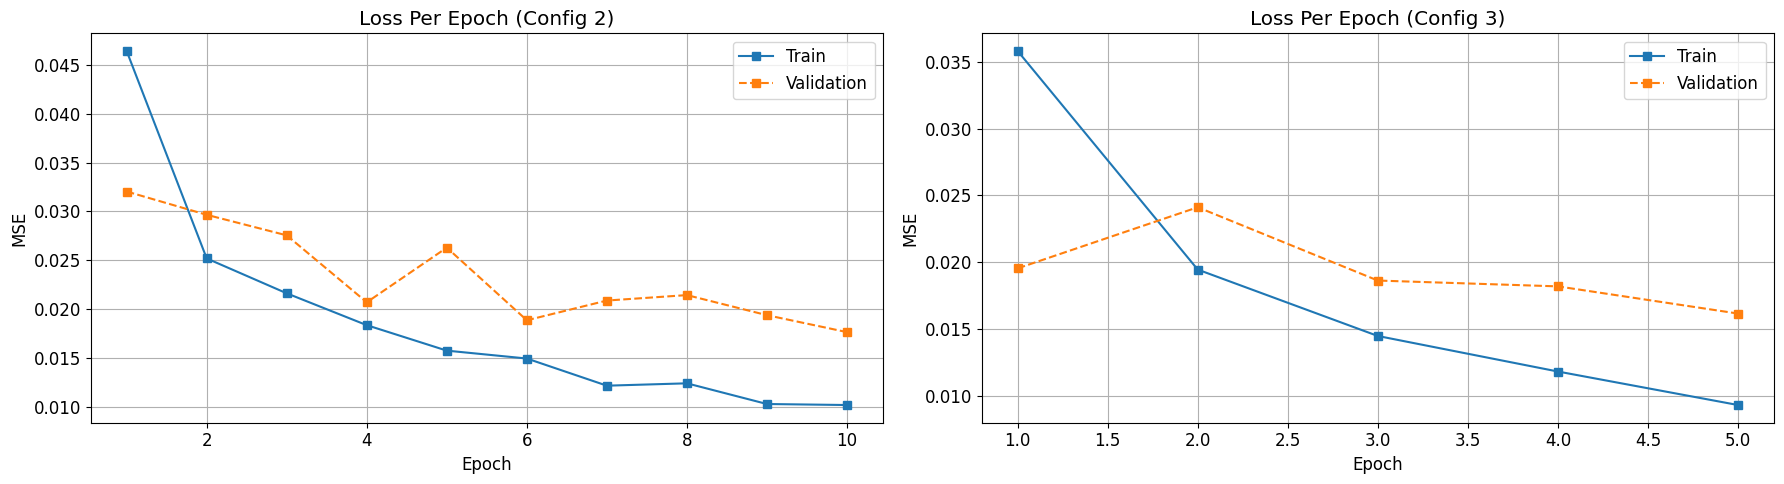

In [59]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))  # 1 row, 3 columns

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


# Scatter Plot with Regression Line

In [60]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p2')
model = RegressionModel('indobenchmark/indobert-lite-base-p2', pooling_type='cls').to('cuda')
def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/balancing/cross/bert_classifier_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in config_df.itertuples():
    all_predictions, all_targets = predict(df_test, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "bert_predictions_indo1.csv"))


>> Tanpa Augmentasi - predicted_score_2
RMSE: 0.1056, Pearson: 0.9167

>> Dengan Augmentasi - predicted_score_3
RMSE: 0.1022, Pearson: 0.9250


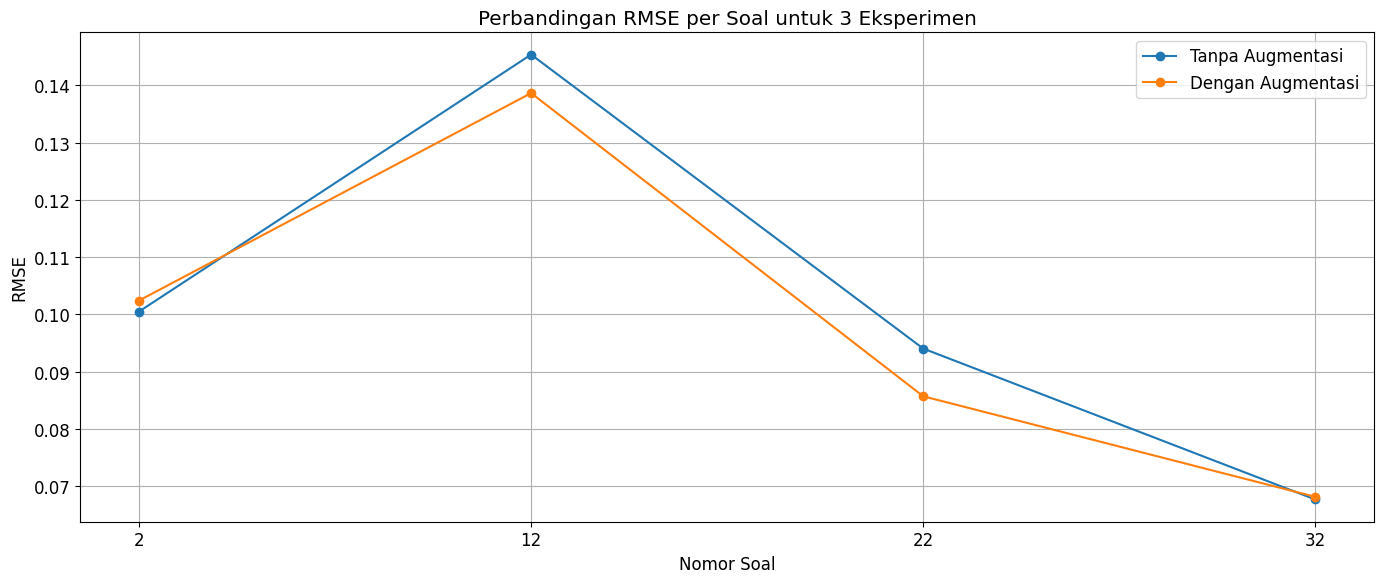

In [62]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

# Folder inference
inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("bert")]

# Warna akan di-generate otomatis tergantung jumlah eksperimen
color_palette = plt.get_cmap("tab10")  # Bisa memuat hingga 10 warna berbeda

# Label eksperimen bisa ditentukan manual berdasarkan nama kolom prediksi
label_map = {
    "predicted_score_2": "Tanpa Augmentasi",
    "predicted_score_3": "Dengan Augmentasi"
}

# Dictionary untuk menyimpan RMSE per soal dari tiap eksperimen
rmse_per_model = {}
metric_eval_data = {}
# Buat scatter plot dan hitung RMSE per soal
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        # Hitung metrik global
        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col)  # Default pakai nama kolom kalau tidak ditemukan
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        # Hitung RMSE per soal
        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

# Ekstrak nomor soal dari dataset_num (misalnya 'analisis_essay-19' -> 19)
def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

# Plot gabungan RMSE per soal
plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    # Ekstrak nomor soal
    soal_numbers = extract_soal_number(rmse_series.index)
    
    # Gabungkan kembali ke Series dengan index numerik
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    # Plot
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))  # Lebih rapi dan terbaca
plt.tight_layout()
plt.show()



In [63]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])

# Visualisasi scatter plot untuk tiap model
num_models = len(model_data)
outlier_count = {}

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    # Deteksi outlier IQR global & fixed threshold
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

        # Hitung jumlah outlier
    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    # Cetak hasil
    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")
    outlier_count[label] = {
        "IQR Fixed Threshold ±0.2": num_outliers_fixed2,
        "IQR Fixed Threshold ±0.1": num_outliers_fixed
    }

Dengan Augmentasi:
  Outlier (Fixed ±0.2): 13
  Outlier (Fixed ±0.1): 57

Tanpa Augmentasi:
  Outlier (Fixed ±0.2): 15
  Outlier (Fixed ±0.1): 64



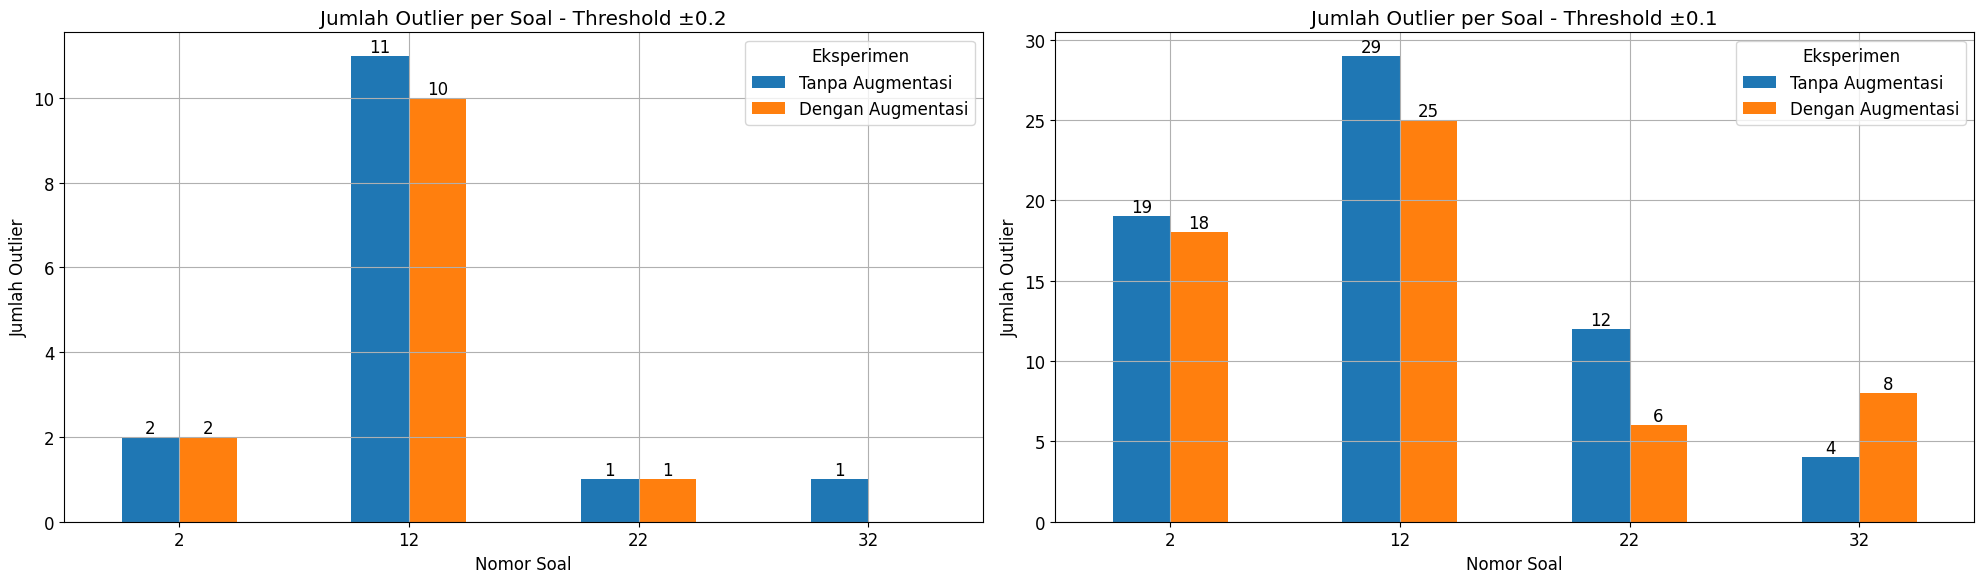

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

outlier_counts_fixed2 = {}
outlier_counts_fixed1 = {}

fixed_threshold2 = 0.2
fixed_threshold1 = 0.1

# Step 3: Hitung jumlah outlier per soal (IQR Global & Fixed)
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores

        outlier_mask_fixed2 = np.abs(residuals) > fixed_threshold2
        outlier_mask_fixed1 = np.abs(residuals) > fixed_threshold1

        df['outlier_fixed2'] = outlier_mask_fixed2
        df['outlier_fixed1'] = outlier_mask_fixed1

        label = label_map.get(col, col)

        # Fixed Threshold
        fixed_counts2 = df[df['outlier_fixed2']].groupby('soal_num').size()
        outlier_counts_fixed2[label] = fixed_counts2

        fixed_counts1 = df[df['outlier_fixed1']].groupby('soal_num').size()
        outlier_counts_fixed1[label] = fixed_counts1

df_fixed2 = pd.DataFrame(outlier_counts_fixed2).fillna(0).astype(int).sort_index()
df_fixed1 = pd.DataFrame(outlier_counts_fixed1).fillna(0).astype(int).sort_index()

import matplotlib.pyplot as plt

# Set default font size globally
plt.rcParams.update({'font.size': 12})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot untuk Threshold ±0.2
df_fixed2.plot(kind='bar', ax=ax1)
ax1.set_title("Jumlah Outlier per Soal - Threshold ±0.2")
ax1.set_xlabel("Nomor Soal")
ax1.set_ylabel("Jumlah Outlier")
ax1.grid(True)
ax1.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax1.tick_params(axis='x', rotation=0, labelsize=12)

# Tambahkan teks di atas bar (ax1)
for container in ax1.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax1.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

# Plot untuk Threshold ±0.1
df_fixed1.plot(kind='bar', ax=ax2)
ax2.set_title("Jumlah Outlier per Soal - Threshold ±0.1")
ax2.set_xlabel("Nomor Soal")
ax2.set_ylabel("Jumlah Outlier")
ax2.grid(True)
ax2.legend(title="Eksperimen", fontsize=12, title_fontsize=12)
ax2.tick_params(axis='x', rotation=0, labelsize=12)

# Tambahkan teks di atas bar (ax2)
for container in ax2.containers:
    for bar in container:
        height = bar.get_height()
        if height > 0:
            ax2.text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=12
            )

plt.tight_layout()
plt.show()




In [65]:
print("Metrik Evaluation")
print(metric_eval_data)
print("Jumlah Outlier Per Metode IQR")
print(outlier_count)
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1 (key = nomor soal, value = jumlah outlier)")
print(df_fixed.to_json())
print("Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2 (key = nomor soal, value = jumlah outlier)")
print(df_fixed2.to_json())

Metrik Evaluation
{'Tanpa Augmentasi': {'RMSE': 0.1056, 'Pearson': 0.9167}, 'Dengan Augmentasi': {'RMSE': 0.1022, 'Pearson': 0.925}}
Jumlah Outlier Per Metode IQR
{'Dengan Augmentasi': {'IQR Fixed Threshold ±0.2': 13, 'IQR Fixed Threshold ±0.1': 57}, 'Tanpa Augmentasi': {'IQR Fixed Threshold ±0.2': 15, 'IQR Fixed Threshold ±0.1': 64}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.1 (key = nomor soal, value = jumlah outlier)
{"Tanpa Augmentasi":{"2":19,"12":29,"22":12,"32":4},"Dengan Augmentasi":{"2":18,"12":25,"22":6,"32":8}}
Jumlah Outlier Per Soal Metode IQR Fixed Threshold +-0.2 (key = nomor soal, value = jumlah outlier)
{"Tanpa Augmentasi":{"2":2,"12":11,"22":1,"32":1},"Dengan Augmentasi":{"2":2,"12":10,"22":1,"32":0}}


In [66]:
import json

interesting_num = [12]
for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]
    df['soal_num'] = df['dataset_num'].str.extract(r'-(\d+)$').astype(int)

    for col in pred_cols:
        residuals = df[col].values - true_scores
        outlier_mask = np.abs(residuals) > fixed_threshold1

        subset_iqr = df[outlier_mask][['soal_num', 'question', 'reference_answer', 'answer', 'normalized_score', col]]
        subset_iqr = subset_iqr[subset_iqr['soal_num'].isin(interesting_num)]
        if not subset_iqr.empty:
            print(f"\nIQR Outliers untuk eksperimen: {label_map.get(col, col)}")
            print(subset_iqr.to_json(orient="records", indent=2, force_ascii=False))



IQR Outliers untuk eksperimen: Tanpa Augmentasi
[
  {
    "soal_num":12,
    "question":"Apa yang anda ketahui mengenai PSSI? (Termasuk pengertian, organisasi yang tergabung dan ketua umum saat ini) ",
    "reference_answer":"pssi adalah persatuan sepak bola seluruh indonesia organisasi induk yang bertugas mengatur kegiatan olahraga sepak bola di indonesia pssi bergabung dengan fifa dan dengan afc pssi menggelar kompetisi liga indonesia setiap tahunnya dan piala indonesia ketua umum pssi sekarang adalah la nyalla mattalitti",
    "answer":"setahuku itu adalah organisasi persatuan sepak nola se indonesia selebihnya belum mengetahui",
    "normalized_score":0.13,
    "predicted_score_2":0.23072004
  },
  {
    "soal_num":12,
    "question":"Apa yang anda ketahui mengenai PSSI? (Termasuk pengertian, organisasi yang tergabung dan ketua umum saat ini) ",
    "reference_answer":"pssi adalah persatuan sepak bola seluruh indonesia organisasi induk yang bertugas mengatur kegiatan olahraga sepa